In [6]:
import argparse
import json
import math
import os
import pickle
import shutil
from collections import namedtuple
from copy import deepcopy

import numpy as np
import pandas as pd
import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer, APPOTrainer
from ray.rllib.evaluation.metrics import collect_episodes, summarize_episodes
from ray.tune.registry import register_env
from tqdm import tqdm

import pycigar
from pycigar.utils.input_parser import input_parser
from pycigar.utils.logging import logger
from pycigar.utils.output import plot_new
from pycigar.utils.registry import make_create_env
import matplotlib.pyplot as plt

In [7]:
misc_inputs_path = pycigar.DATA_DIR + "/ieee37busdata/misc_inputs.csv"
dss_path = pycigar.DATA_DIR + "/ieee37busdata/ieee37.dss"
load_solar_path = pycigar.DATA_DIR + "/ieee37busdata/load_solar_data.csv"
breakpoints_path = pycigar.DATA_DIR + "/ieee37busdata/breakpoints.csv"

sim_params = input_parser(misc_inputs_path, dss_path, load_solar_path, breakpoints_path)
sim_params['M'] = 10
sim_params['N'] = 0.1
sim_params['P'] = 18
sim_params['Q'] = 50
sim_params['env_config']['sims_per_step'] = 20
sim_params['attack_randomization']['generator'] = 'AttackDefinitionGeneratorEvaluation'

pycigar_params = {"exp_tag": "cooperative_multiagent_ppo",
                    "env_name": "CentralControlPVInverterEnv",
                    "simulator": "opendss"}
create_env, env_name = make_create_env(pycigar_params, version=0)
register_env(env_name, create_env)

test_env = create_env(sim_params)
test_env.observation_space  # get the observation space, we need this to construct our agent(s) observation input
test_env.action_space  # get the action space, we need this to construct our agent(s) action output

Discrete(5)

In [8]:
log_dicts = {}
custom_metrics = {}
random_rl_update = None
clone_random_rl_update = None
for case in range(4):
    for i in range(4):
        done = False
        obs = test_env.reset()
        #custom_metrics = logger().custom_metrics
        #print(custom_metrics['start_time'], custom_metrics['hack'])
        obs = obs.tolist()
        j = 0
        begin_hack = 13
        end_hack = 25
        act_step_down = 1
        act_step_up = 3
        act = act_init = 2
        while not done:
            j += 1
            
            if case == 0: # step down and no up 
                if j == begin_hack:
                    act = act_step_down
            
            elif case == 1: # step down and init 
                if j == begin_hack:
                    act = act_step_down
                if j == end_hack:
                    act = act_init

            elif case == 2: # step down up no init
                if j == begin_hack and logger().custom_metrics['hack'] == 0.2:
                    act = act_step_up
                if j == begin_hack and logger().custom_metrics['hack'] != 0.2:
                    act = act_step_down                
            
            elif case == 3: # step down up and init
                if j == begin_hack and logger().custom_metrics['hack'] == 0.2:
                    act = act_step_up
                if j == begin_hack and logger().custom_metrics['hack'] != 0.2:
                    act = act_step_down  
                if j == end_hack:
                    act = act_init

            if clone_random_rl_update:
                obs, r, done, _ = test_env.step(act, clone_random_rl_update.pop(0))
            else:
                obs, r, done, _ = test_env.step(act)
            obs = obs.tolist()
        log_dicts[(case, logger().custom_metrics['start_time'], logger().custom_metrics['hack'])] = deepcopy(logger().log_dict)
        custom_metrics[(case, logger().custom_metrics['start_time'], logger().custom_metrics['hack'])] = deepcopy(logger().custom_metrics)
        if not random_rl_update: 
            random_rl_update = deepcopy(logger().custom_metrics['randomize_rl_update'])
        clone_random_rl_update = deepcopy(random_rl_update)
        print(case, i)

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3


In [9]:
def plot_all(log_dicts, custom_metrics):
    colors = {(100, 0.2): 'tab:blue',
             (11000, 0.2): 'tab:purple',
             (100, 0.45): 'tab:orange',
             (11000, 0.45): 'tab:red', 
            }

    rows = {(100, 0.2): 0,
             (11000, 0.2): 1,
             (100, 0.45): 2,
             (11000, 0.45): 3, 
            }
    def get_translation_and_slope(a_val, init_a):
        points = np.array(a_val)
        slope = points[:, 1] - points[:, 0]
        translation = points[:, 2] - init_a[2]
        return translation, slope

    plt.rc('font', size=15)
    plt.rc('figure', titlesize=35)
    inv_k = 'inverter_s701a'
    f, ax = plt.subplots(11, 4, figsize=(60, 60))
    title = '[M {}][N {}][P {}][Q {}][sim {:d}]'.format(sim_params['M'], sim_params['N'], sim_params['P'], sim_params['Q'], sim_params['env_config']['sims_per_step'])
    f.suptitle(title)
    
    average_reward = {0: [],
                      1: [],
                      2: [],
                      3: [],
                      }

    for key in log_dicts.keys():
        ax[0, key[0]].plot(log_dicts[key][log_dicts[key][inv_k]['node']]['voltage'], color=colors[key[1:]], label='v ' + str(key[1:]))
        ax[1, key[0]].plot(log_dicts[key][inv_k]['y'], color=colors[key[1:]], label='y' + str(key[1:]))
        
        translation, slope = get_translation_and_slope(log_dicts[key][inv_k]['control_setting'], custom_metrics[key]['init_control_settings'][inv_k])
        ax[2, key[0]].plot(translation, color=colors[key[1:]], label='a '  + str(key[1:]))

        ax[3, key[0]].plot(log_dicts[key][inv_k]['sbar_solarirr'], color=colors[key[1:]], label='sbar solar '  + str(key[1:]))
        ax[4, key[0]].plot(log_dicts[key][inv_k]['sbar_pset'], color=colors[key[1:]], label='sbar pset ' + str(key[1:]))

        ax[5, key[0]].plot(log_dicts[key]['component_observation']['component_y'], color=colors[key[1:]], label='obs_y ' + str(key[1:]))
        ax[6, key[0]].plot(log_dicts[key]['component_observation']['component_ymax'], color=colors[key[1:]], label='obs_ymax ' + str(key[1:]))

        
        component_y = np.array(log_dicts[key]['component_reward']['component_y'])
        component_oa = np.array(log_dicts[key]['component_reward']['component_oa'])
        component_init = np.array(log_dicts[key]['component_reward']['component_init'])
        component_pset_pmax = np.array(log_dicts[key]['component_reward']['component_pset_pmax'])

        total_reward = (component_y + component_oa + component_init + component_pset_pmax)

        average_reward[key[0]].append(sum(total_reward)/sim_params['env_config']['sims_per_step'])
        ax[7 + rows[key[1:]], key[0]].plot(-component_y, label='abs_reward_y')
        ax[7 + rows[key[1:]], key[0]].plot(-component_oa, label='abs_reward_oa')
        ax[7 + rows[key[1:]], key[0]].plot(-component_init, label='abs_reward_init ')
        ax[7 + rows[key[1:]], key[0]].plot(-component_pset_pmax, label='abs_reward_pset_pmax')
        ax[7 + rows[key[1:]], key[0]].plot(-total_reward, label='abs_total_reward')
        ax[7 + rows[key[1:]], key[0]].set_title('{} total r: {:.2f}, r on s701a: {:.2f}'.format(key[1:], sum(total_reward)/sim_params['env_config']['sims_per_step'], sum(log_dicts[key][inv_k]['reward'])))
        
    for key in log_dicts.keys():
        avg = sum(average_reward[key[0]])/len(average_reward[key[0]])
        ax[0, key[0]].set_title('average eval: {:.2f}'.format(avg))

    for i in range(11):
        for j in range(4):
            ax[i,j].grid(b=True, which='both')
            ax[i,j].legend(loc=1, ncol=2)
            
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    return f

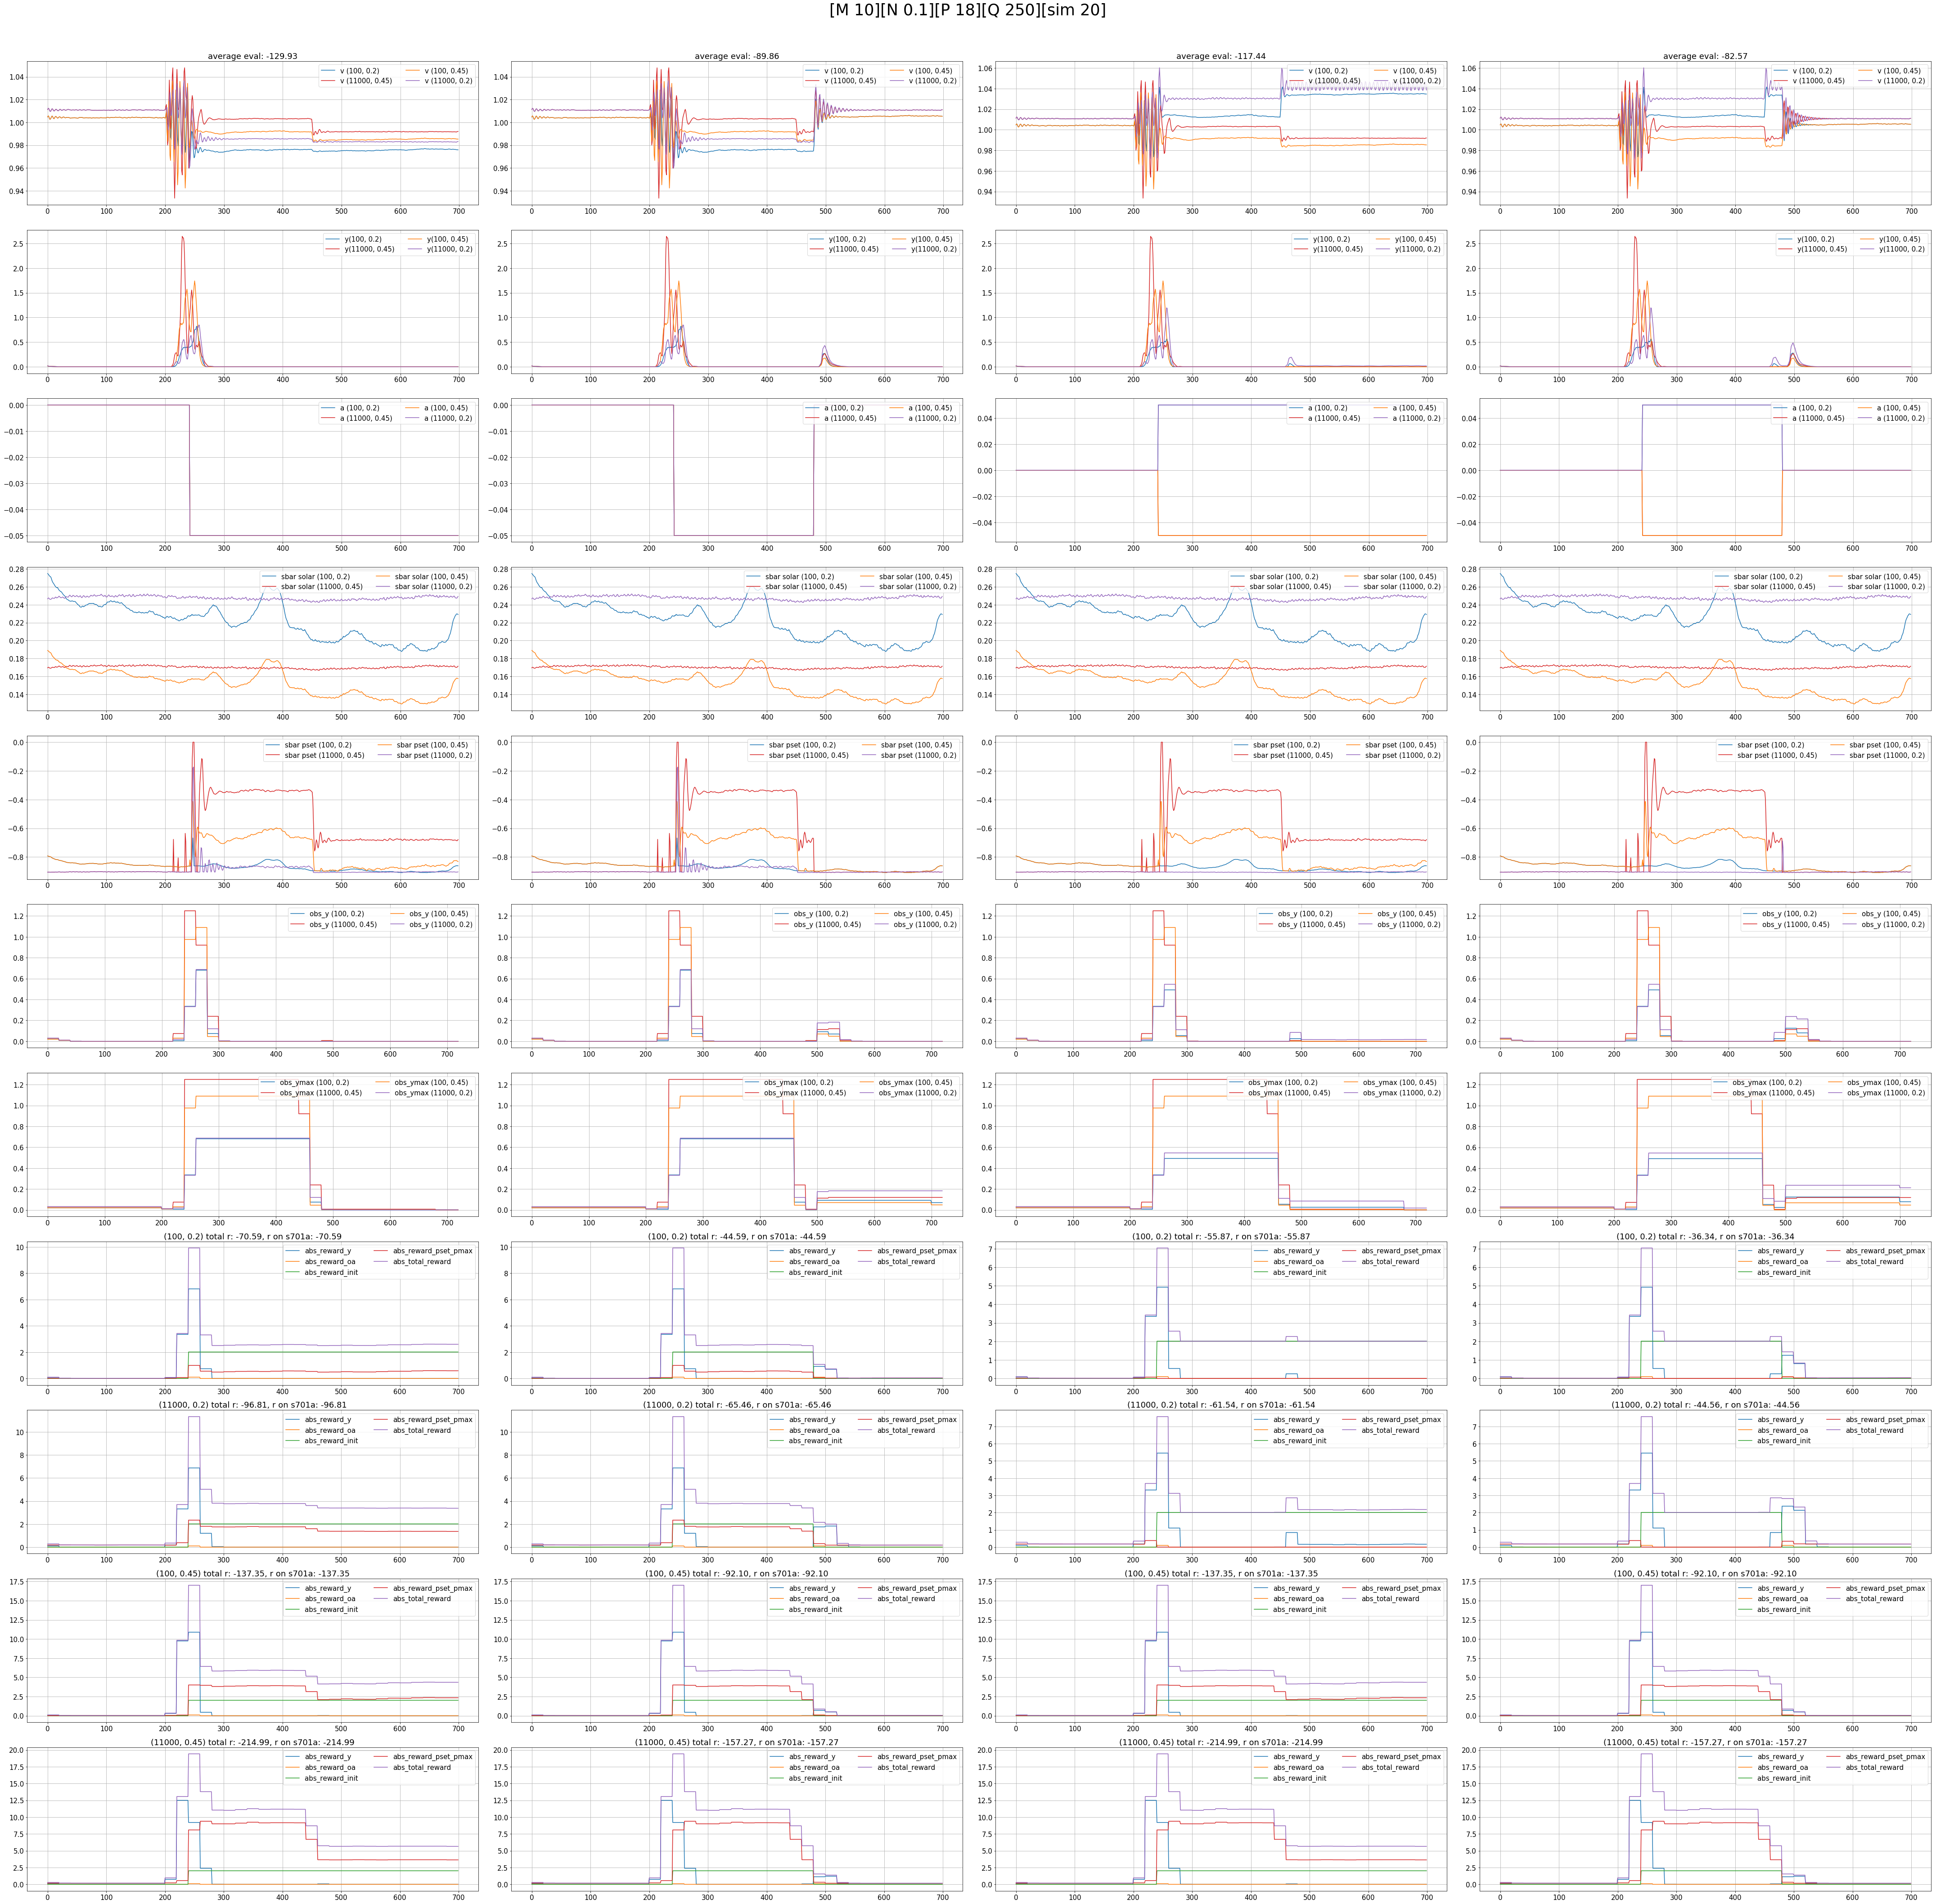

In [10]:
f = plot_all(log_dicts, custom_metrics)
plt.show()